# Attention-based MIL demo.

In order to easily demonstrate and understand the predictions from an attention-based MIL model, we use a simple data that generates images containing different kinds of shapes with specified probabilities.



## Creating a dataset

The ``ShapesDataset`` object produces images with a uniform random background colour, as well as a a scattering randomly-colours shapes, placed at random positions. The dataset does not repeat itself, so we don't need to bother creating a separate validation set.


In this demo, we are going to tile individual images to the attention part of the model can provide an attention weighting for indivudial regions. As such, we will only use a batch size of one.

In [1]:
from torch_tools import ShapesDataset
from torch.utils.data import DataLoader

from torch import zeros, rand, no_grad

from torchvision.transforms import Compose, ElasticTransform, RandomErasing
from torchvision.transforms import RandomRotation

img_size = 512
patch_size = 64

print(f"Bag size = {(img_size // patch_size) ** 2}")

train_set = ShapesDataset(
    spot_prob=1.0,
    square_prob=1.0,
    octagon_prob=1.0,
    star_prob=0.5,
    input_tfms=Compose(
        [
            ElasticTransform(alpha=(0.0, 50.0)),
            # RandomErasing(),
            RandomRotation(180.0),
        ]
    ),
    target_tfms=Compose([lambda x: x[1]]),
    image_size=img_size,
    num_shapes=3,
    seed=1234,
)

valid_set = ShapesDataset(
    spot_prob=1.0,
    square_prob=1.0,
    octagon_prob=1.0,
    star_prob=0.5,
    target_tfms=Compose([lambda x: x[1]]),
    image_size=img_size,
    num_shapes=3,
    seed=1234,
)


train_loader = DataLoader(
    train_set,
    shuffle=True,
    batch_size=1,
    drop_last=True,
)

valid_loader = DataLoader(
    valid_set,
    shuffle=False,
    batch_size=1,
    drop_last=True,
)

Bag size = 64


### Visualising some example images

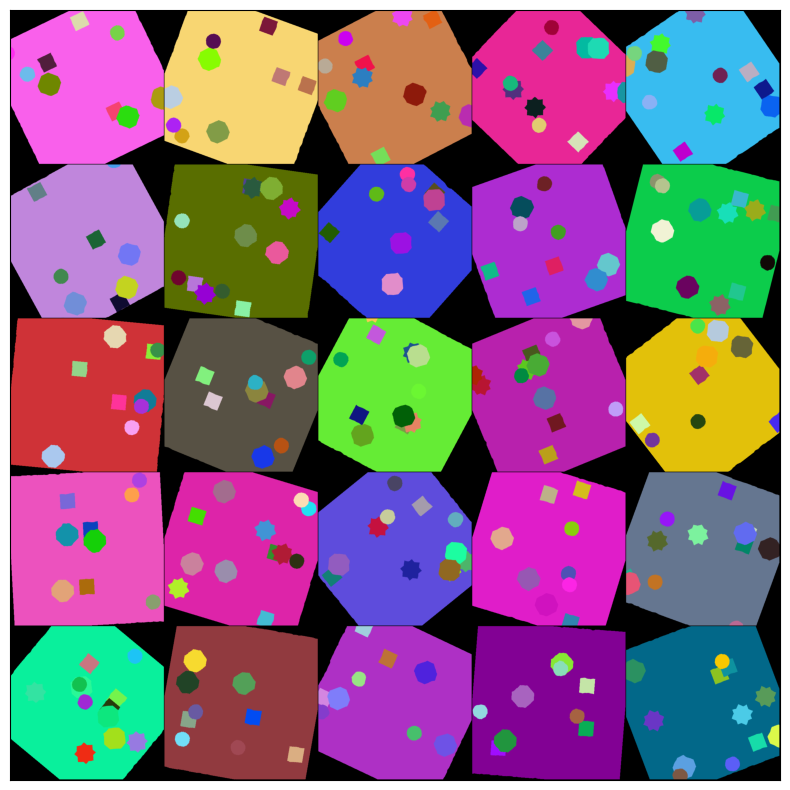

In [2]:
from torch import concat
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

images = []
for idx, (batch, _) in enumerate(train_loader):
    if idx == 25:
        break

    images.append(batch)


grid = make_grid(concat(tuple(images), dim=0), nrow=5).permute(1, 2, 0)


figure, axis = plt.subplots(1, 1, figsize=(8, 8))

axis.imshow(grid)

axis.set_xticks([])
axis.set_yticks([])

figure.tight_layout()

Notice that all of the images contain spots, squares, and octogons, but only contain stars with probability 0.5. For this demo, we will make the star-containing images the positive class.

When training the attention model, we are only going to supply the model with one image at a time, but that image will be presented in a mini-batch-like, tesselated form. We visualise such an example in the following:


### Visualising a tesselated image

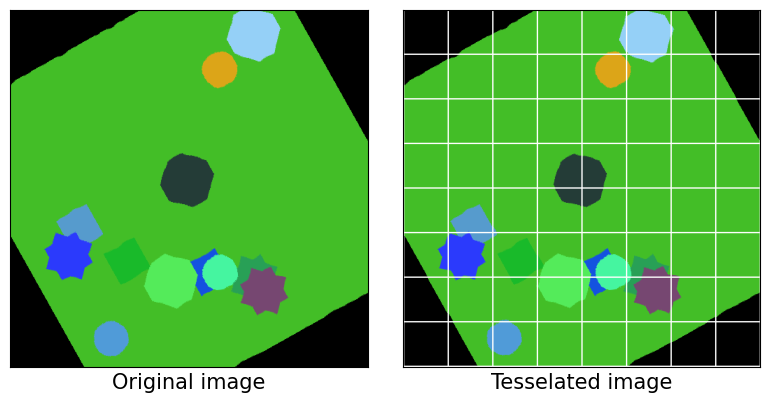

In [3]:
from torch_tools.torch_utils import patchify_img_batch

for batch, target in train_loader:
    if target.item() == 1.0:
        break

patches = make_grid(
    patchify_img_batch(batch, patch_size),
    nrow=8,
    pad_value=1.0,
)

figure, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(batch.squeeze(0).permute(1, 2, 0), extent=(0, 1, 0, 1))
axes[1].imshow(patches.permute(1, 2, 0), extent=(0, 1, 0, 1))

axes[0].set_xlabel("Original image", fontsize=15)
axes[1].set_xlabel("Tesselated image", fontsize=15)

for axis in axes.ravel():
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlim(left=0.0, right=1.0)
    axis.set_ylim(bottom=0.0, top=1.0)

figure.tight_layout()

## Creating the attention model

In [4]:
import torch
from torch.nn import Module, Linear, Sequential, Tanh
from torch.nn import BatchNorm2d, InstanceNorm2d
from torch.optim import Adam

from torch.cuda import is_available

from torch_tools import ConvNet2d, FCNet, SimpleConvNet2d, Encoder2d


DEVICE = "cuda" if is_available() else "cpu"


class AttentionNet(Module):
    """Attention model."""

    def __init__(self):
        """Build attention model."""
        super().__init__()

        self.latent = 128
        self.D = 128

        self.encoder = ConvNet2d(
            self.latent,
            encoder_style="resnet18",
            pretrained=True,
        )

        self.attention = Linear(self.latent, 1)
        self.classifier = FCNet(self.latent, 1)

    def forward(self, batch):
        """Pass ``batch`` through the model."""
        latent = self.encoder(batch).relu()

        # Compute attention and reshape to (num_feats, num_instances)
        attention = self.attention(latent).transpose(1, 0).softmax(dim=1)

        # Weight the features of each instance by their attention score
        matrix = torch.mm(attention, latent)

        # Classify the weighted features
        classification = self.classifier(matrix).sigmoid()

        return classification, attention


model = AttentionNet()
print(model)

AttentionNet(
  (encoder): ConvNet2d(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, e

### A slight hack

Switching the batch normalisation layers to instance normalisation layers seem to hugely improve the stability of the model in eval mode, so we do it here.

In [5]:
from torch.nn import Module, Sequential
from torch_tools.weight_init import normal_init
from torch import zeros_like, ones_like


def batch_norm_to_instance_norm(layer: Module):
    """Turn the batch normalisation layers to instance normalisations.

    Parameters
    ----------
    layer : Module
        Layer in the network.

    """
    for name, module in layer.named_children():
        if isinstance(module, BatchNorm2d):
            setattr(layer, name, InstanceNorm2d(module.num_features))


model.apply(batch_norm_to_instance_norm)

model.to(DEVICE)


print(model)


optimiser = Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

AttentionNet(
  (encoder): ConvNet2d(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): In

## Training the model

In [6]:
from typing import Optional, Dict

from torch import set_grad_enabled
from torch.nn.functional import binary_cross_entropy as bce
from torch import rand
from torch.nn.functional import normalize

from numpy import mean


def one_epoch(
    model: Module,
    data_loader: DataLoader,
    optimiser: Optional[Adam] = None,
):
    """Train or validate the model for a single epoch.

    Parameters
    ----------
    model : Module
        Classifier model.
    data_loader : DataLoader
        Image-yielding data loader.
    optimiser : Adam, optional
        The optimiser to fit the model with.

    """
    metrics = {"loss": [], "accuracy": []}

    if optimiser is not None:
        model.train()
    else:
        model.eval()

    for image, target in data_loader:
        if optimiser is not None:
            optimiser.zero_grad()

        image, target = image.to(DEVICE), target.to(DEVICE)

        target = target.reshape(1, 1)

        bag = patchify_img_batch(image, patch_size)

        with set_grad_enabled(optimiser is not None):
            pred, atten = model(bag)

        loss = bce(pred, target)

        metrics["loss"].append(loss.item())
        metrics["accuracy"].append((pred.item() >= 0.5) == target.item())

        if optimiser is not None:
            loss.backward()
            optimiser.step()

    return {key: mean(val) for key, val in metrics.items()}

In [7]:
from time import perf_counter

epochs = 10

train_metrics, valid_metrics = [], []

for epoch in range(epochs):
    start_time = perf_counter()

    train_metrics.append(one_epoch(model, train_loader, optimiser))
    valid_metrics.append(one_epoch(model, valid_loader))

    stop_time = perf_counter()

    print(f"Epoch {epoch + 1} time = {stop_time - start_time:.6f} seconds")

Epoch 1 time = 50.686830 seconds
Epoch 2 time = 50.773120 seconds
Epoch 3 time = 50.998185 seconds
Epoch 4 time = 50.834512 seconds
Epoch 5 time = 50.635055 seconds
Epoch 6 time = 50.698399 seconds
Epoch 7 time = 50.830427 seconds
Epoch 8 time = 52.246671 seconds
Epoch 9 time = 51.676506 seconds
Epoch 10 time = 51.770302 seconds


## Evaluating the performance

   loss_train  accuracy_train  loss_valid  accuracy_valid  epoch
0    0.702762           0.502    0.683277           0.501      1
1    0.691106           0.553    0.667366           0.540      2
2    0.682572           0.580    0.718344           0.468      3
3    0.649368           0.623    0.708871           0.568      4
4    0.282253           0.886    0.173003           0.949      5
5    0.173901           0.934    0.493322           0.860      6
6    0.069645           0.983    0.096429           0.973      7
7    0.066298           0.984    0.179254           0.958      8
8    0.097798           0.967    0.044914           0.987      9
9    0.085052           0.973    0.012648           0.999     10


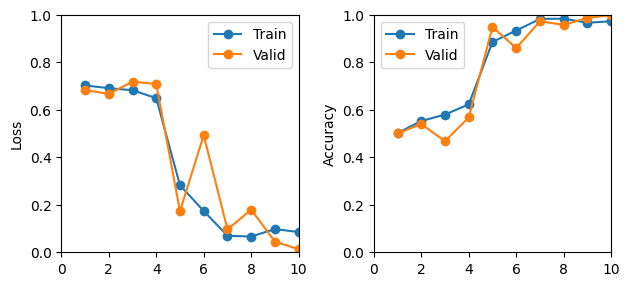

In [8]:
import matplotlib.pyplot as plt
from pandas import DataFrame

from numpy import arange, diff


metrics = DataFrame(train_metrics).join(
    DataFrame(valid_metrics),
    lsuffix="_train",
    rsuffix="_valid",
)
metrics["epoch"] = arange(1, len(metrics) + 1, 1)

print(metrics)


figure, axes = plt.subplots(1, 2)


for axis, metric in zip(axes.ravel(), ["loss", "accuracy"]):
    for split in ["train", "valid"]:
        axis.plot(
            metrics.epoch,
            metrics[f"{metric}_{split}"],
            "-o",
            label=split.capitalize(),
        )

    axis.set_ylabel(metric.capitalize())


for axis in axes.ravel():

    axis.legend()
    axis.set_xlim(left=0, right=epochs)
    axis.set_ylim(bottom=0.0, top=1.0)
    axis.set_aspect(diff(axis.get_xlim()) / diff(axis.get_ylim()))


figure.tight_layout()

## Visualising some results

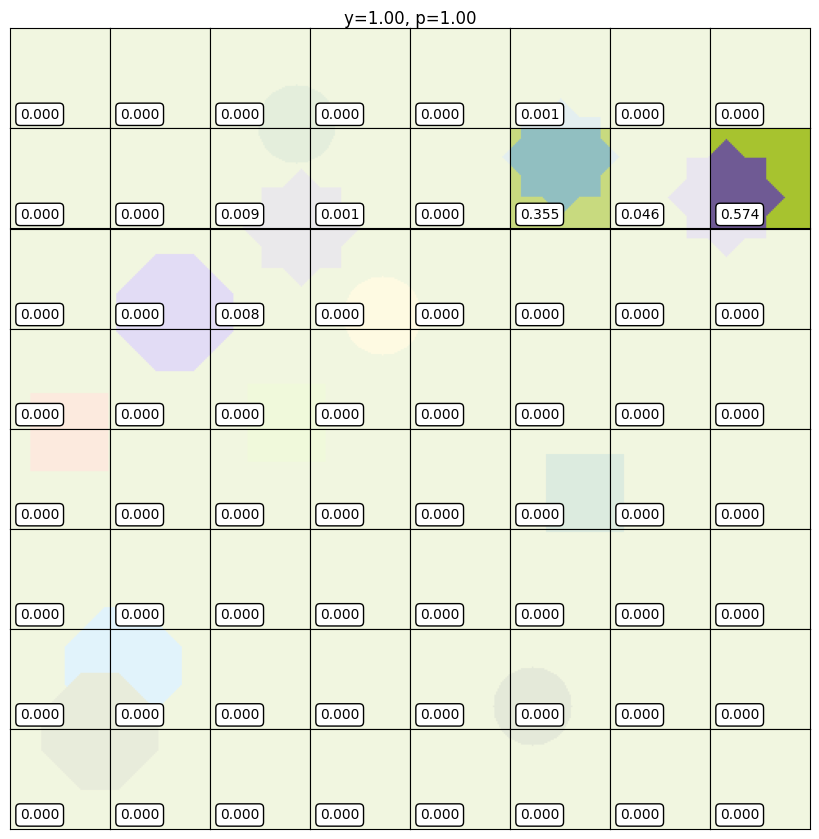

In [9]:
from numpy import round

model.eval()

with no_grad():
    for image, target in valid_loader:
        image = patchify_img_batch(image, patch_size)
        pred, attention = model(image.to(DEVICE))

        if target.item() == 1.0:
            break

attention = attention.cpu().detach().flatten()


alphas = (attention / attention.max()).clip(0.15, 1.0)


patch_length = img_size // patch_size


figure, axes = plt.subplots(patch_length, patch_length, figsize=(8, 8.2))

for patch, axis, att, alpha in zip(image, axes.ravel(), attention, alphas):
    patch = patch.permute(1, 2, 0).numpy()
    axis.imshow(patch, alpha=alpha.item())

    axis.text(
        0.1,
        0.1,
        f"{round(att.item(), 3):.3f}",
        transform=axis.transAxes,
        bbox={"boxstyle": "round", "facecolor": "white"},
    )
    axis.set_xticks([])
    axis.set_yticks([])

figure.suptitle(f"y={target.item():.2f}, p={pred.item():.2f}", y=1.0)
figure.tight_layout(pad=0, h_pad=0.0, w_pad=0)